# 한글 깨짐 방지

In [1]:
!apt-get update
!apt-get install -y fonts-nanum
!fc-cache -fv

Hit:1 https://mirror.kakao.com/ubuntu focal InRelease
Hit:2 https://mirror.kakao.com/ubuntu focal-updates InRelease
Hit:3 https://mirror.kakao.com/ubuntu focal-backports InRelease
Hit:4 https://mirror.kakao.com/ubuntu focal-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory

# JSON 확인

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
from pathlib import Path

# ---------------- 기본 경로 ----------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove")
CSV_PATH = BASE_DIR / "data" / "metadata.csv"

# ---------------- CSV 불러오기 ----------------
df = pd.read_csv(CSV_PATH)

# ---------------- sample_data 개수 세기 ----------------
df_sample = df[df["video_path"].str.contains("sample_data")]
print("[INFO] sample_data 비디오 개수:", len(df_sample))


[INFO] sample_data 비디오 개수: 75


In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 찾기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)

# 전역 설정
plt.rc("font", family=fontprop.get_name())
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지

# ---------------- 기본 경로 ----------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove")
CSV_PATH = BASE_DIR / "data" / "metadata.csv"

# ---------------- keypoints 불러오기 함수 ----------------
def load_keypoints(json_path: Path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if "instance_info" in data and len(data["instance_info"]) > 0:
        return np.array(data["instance_info"][0]["keypoints"])  # (N,2)
    else:
        return np.zeros((0, 2))

# ---------------- metadata 불러오기 ----------------
df = pd.read_csv(CSV_PATH)
row = df[df["video_path"].str.contains("sample_data")].iloc[0]
video_path = BASE_DIR / "data" / row["video_path"]
keypoints_dir = BASE_DIR / "data" / row["keypoints_path"]

print(f"[INFO] 선택된 비디오: {video_path.name}")
print("[INFO] keypoints_dir:", keypoints_dir)

# ---------------- JSON 파일 로드 ----------------
json_files = sorted(keypoints_dir.glob("*.json"))
print("[INFO] 총 JSON 파일 개수:", len(json_files))

[INFO] 선택된 비디오: 경사진 침대에서 가슴 열기.MP4
[INFO] keypoints_dir: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/2_KEYPOINTS/sample_data/ICU_sample_video/경사진 침대에서 가슴 열기_JSON
[INFO] 총 JSON 파일 개수: 410


In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def analyze_pose(json_files):
    """
    1) 12개 주요 keypoints (좌표 X/Y + 이동거리)
    2) 8개 주요 관절 각도 (0~360)
    를 분석하고, 상체/하체로 나눠 시각화
    """

    # ---------------- keypoints 로드 ----------------
    def load_keypoints(json_path: Path):
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" in data and len(data["instance_info"]) > 0:
            return np.array(data["instance_info"][0]["keypoints"])
        return np.zeros((0, 2))

    # ---------------- 0~360 각도 계산 ----------------
    def compute_angle(a, b, c):
        ba = a - b
        bc = c - b
        angle = np.degrees(np.arctan2(bc[1], bc[0]) - np.arctan2(ba[1], ba[0]))
        if angle < 0:
            angle += 360
        return angle

    # ---------------- 분석 대상 keypoints ----------------
    tracked_ids = {
        5: "left_shoulder", 6: "right_shoulder",
        7: "left_elbow",    8: "right_elbow",
        9: "left_wrist",   10: "right_wrist",
        11: "left_hip",    12: "right_hip",
        13: "left_knee",   14: "right_knee",
        15: "left_ankle",  16: "right_ankle"
    }

    coords = {name: {"x": [], "y": []} for name in tracked_ids.values()}
    movements = []
    prev_points = None

    # ---------------- 각도 저장 ----------------
    angles = {
        "left_elbow": [], "right_elbow": [],
        "left_shoulder": [], "right_shoulder": [],
        "left_knee": [], "right_knee": [],
        "left_hip": [], "right_hip": []
    }

    # ---------------- JSON 순회 ----------------
    for f in json_files:
        pts = load_keypoints(f)
        if len(pts) == 0:
            continue

        # 좌표 기록
        for k, name in tracked_ids.items():
            coords[name]["x"].append(pts[k][0])
            coords[name]["y"].append(pts[k][1])

        # 이동거리 (12개 관절 평균)
        if prev_points is not None:
            diffs = np.linalg.norm(pts - prev_points, axis=1)
            mean_diff = np.mean(diffs[list(tracked_ids.keys())])
            movements.append(mean_diff)

        # 관절 각도
        angles["left_elbow"].append(compute_angle(pts[5], pts[7], pts[9]))
        angles["right_elbow"].append(compute_angle(pts[6], pts[8], pts[10]))
        angles["left_shoulder"].append(compute_angle(pts[7], pts[5], pts[11]))
        angles["right_shoulder"].append(compute_angle(pts[8], pts[6], pts[12]))
        angles["left_knee"].append(compute_angle(pts[11], pts[13], pts[15]))
        angles["right_knee"].append(compute_angle(pts[12], pts[14], pts[16]))
        angles["left_hip"].append(compute_angle(pts[13], pts[11], pts[5]))
        angles["right_hip"].append(compute_angle(pts[14], pts[12], pts[6]))

        prev_points = pts

    frames = range(len(next(iter(coords.values()))["x"]))

    # ---------------- 시각화 ----------------
    plt.figure(figsize=(18, 12))

    # ---- 상체 ----
    plt.subplot(2, 2, 1)
    plt.plot(angles["left_elbow"], label="Left Elbow Angle")
    plt.plot(angles["right_elbow"], label="Right Elbow Angle")
    plt.plot(angles["left_shoulder"], label="Left Shoulder Angle")
    plt.plot(angles["right_shoulder"], label="Right Shoulder Angle")
    plt.title("상체 관절 각도")
    plt.xlabel("Frame"); plt.ylabel("Angle (deg)")
    plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 2)
    for name in ["left_shoulder","right_shoulder","left_elbow","right_elbow","left_wrist","right_wrist"]:
        plt.plot(frames, coords[name]["y"], label=f"{name} Y")
    plt.title("상체 keypoints Y좌표")
    plt.xlabel("Frame"); plt.ylabel("Y pixel")
    plt.legend(fontsize=8); plt.grid(True)

    # ---- 하체 ----
    plt.subplot(2, 2, 3)
    plt.plot(angles["left_knee"], label="Left Knee Angle")
    plt.plot(angles["right_knee"], label="Right Knee Angle")
    plt.plot(angles["left_hip"], label="Left Hip Angle")
    plt.plot(angles["right_hip"], label="Right Hip Angle")
    plt.title("하체 관절 각도")
    plt.xlabel("Frame"); plt.ylabel("Angle (deg)")
    plt.legend(); plt.grid(True)

    plt.subplot(2, 2, 4)
    for name in ["left_hip","right_hip","left_knee","right_knee","left_ankle","right_ankle"]:
        plt.plot(frames, coords[name]["y"], label=f"{name} Y")
    plt.title("하체 keypoints Y좌표")
    plt.xlabel("Frame"); plt.ylabel("Y pixel")
    plt.legend(fontsize=8); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # ---------------- keypoints X 좌표 ----------------
    plt.figure(figsize=(16, 6))
    for name, v in coords.items():
        plt.plot(frames, v["x"], label=f"{name} X")
    plt.title("12개 KEYPOINTS X 좌표")
    plt.xlabel("Frame"); plt.ylabel("X pixel")
    plt.legend(fontsize=8, ncol=4); plt.grid(True)
    plt.show()

    # ---------------- keypoints Y 좌표 ----------------
    plt.figure(figsize=(16, 6))
    for name, v in coords.items():
        plt.plot(frames, v["y"], label=f"{name} Y")
    plt.title("12개 KEYPOINTS Y 좌표")
    plt.xlabel("Frame"); plt.ylabel("Y pixel")
    plt.legend(fontsize=8, ncol=4); plt.grid(True)
    plt.show()


    return coords, movements, angles


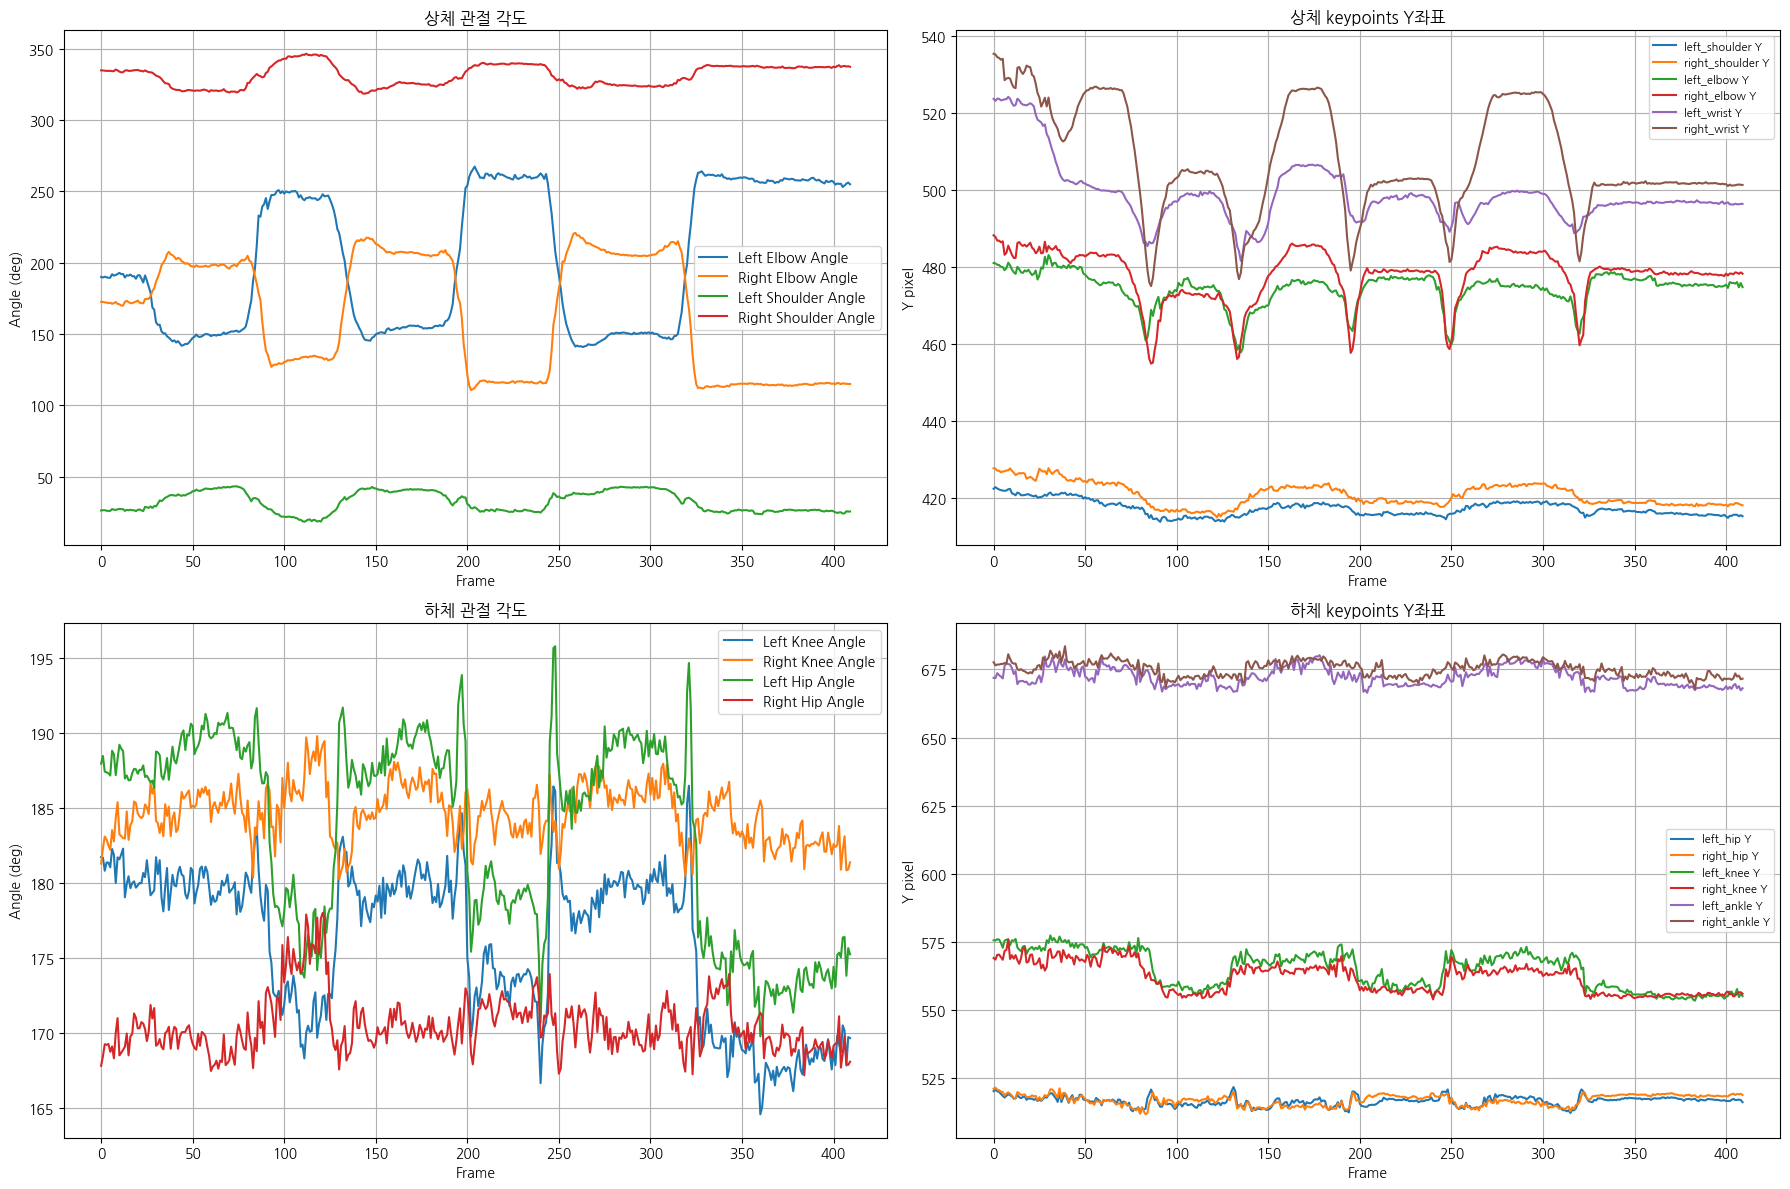

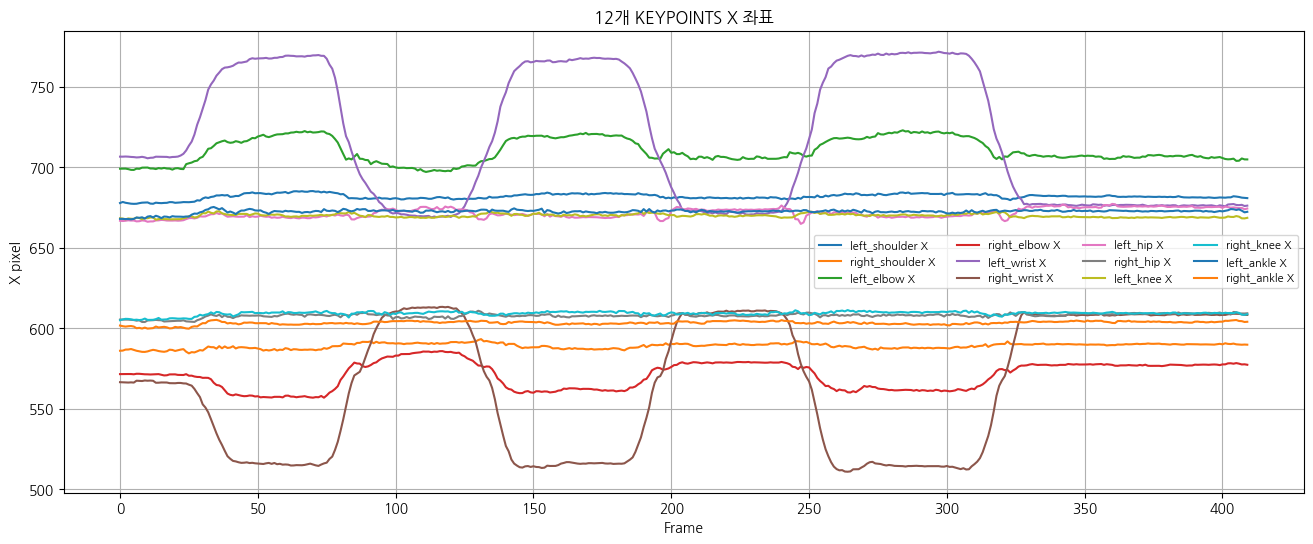

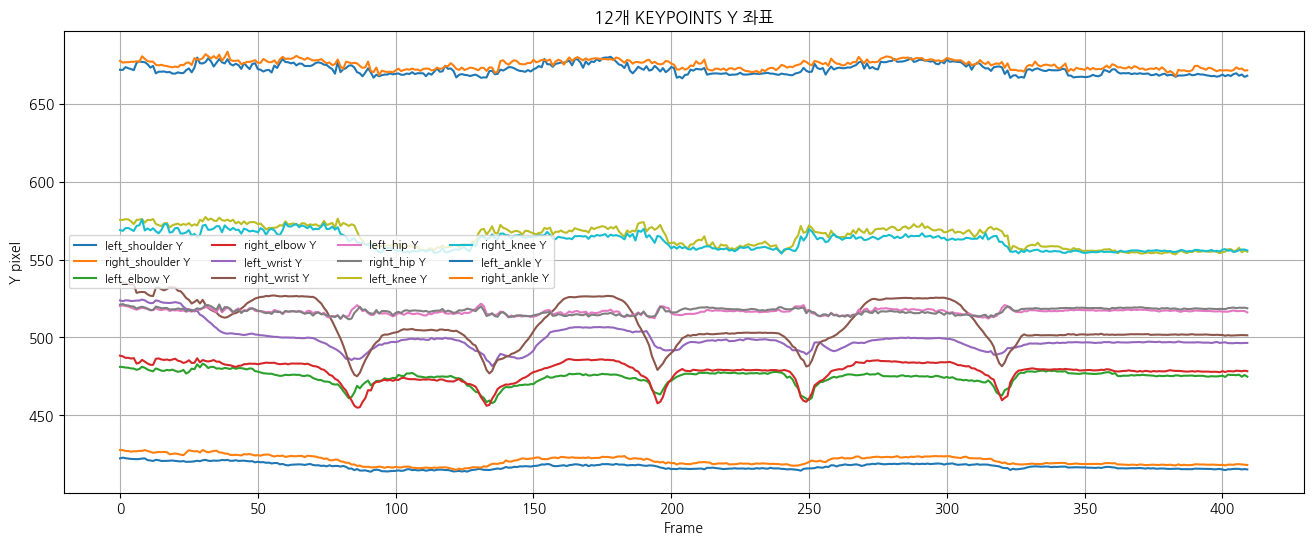

In [12]:
# ---------------- pose 분석 및 시각화 ----------------
coords, movements, angles = analyze_pose(json_files)


[INFO] 분석 대상: 경사진 침대에서 가슴 열기.MP4
[RESULT] Left Elbow reps: 2
[RESULT] Right Elbow reps: 2


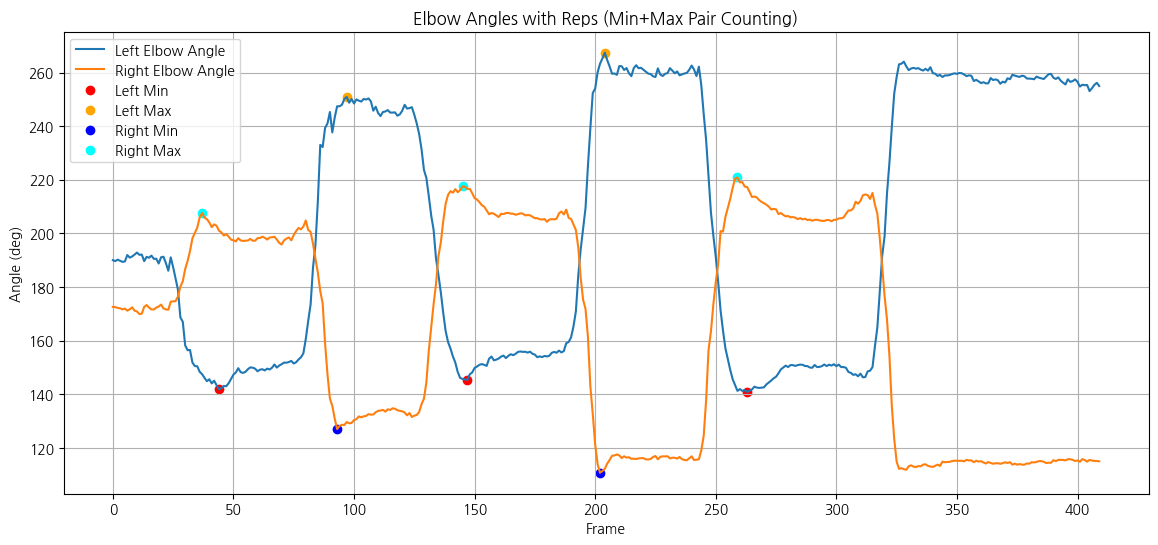

In [19]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ---------------- 기본 설정 ----------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove")
CSV_PATH = BASE_DIR / "data" / "metadata.csv"

# ---------------- keypoints 불러오기 ----------------
def load_keypoints(json_path: Path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if "instance_info" in data and len(data["instance_info"]) > 0:
        return np.array(data["instance_info"][0]["keypoints"])
    return np.zeros((0, 2))

# ---------------- 각도 계산 ----------------
def compute_angle(a, b, c):
    ba = a - b
    bc = c - b
    angle = np.degrees(np.arctan2(bc[1], bc[0]) - np.arctan2(ba[1], ba[0]))
    if angle < 0:
        angle += 360
    return angle

# ---------------- 팔꿈치 각도 수집 ----------------
def get_elbow_angles(json_files):
    left_elbow, right_elbow = [], []

    for f in json_files:
        pts = load_keypoints(f)
        if len(pts) == 0:
            continue
        # 왼쪽 팔꿈치 (어깨-팔꿈치-손목)
        left_elbow.append(compute_angle(pts[5], pts[7], pts[9]))
        # 오른쪽 팔꿈치 (어깨-팔꿈치-손목)
        right_elbow.append(compute_angle(pts[6], pts[8], pts[10]))

    return np.array(left_elbow), np.array(right_elbow)

# ---------------- 반복 횟수 Count (최소+최대 쌍) ----------------
def count_reps_with_pairs(angle_series, prominence=15, distance=10):
    minima, _ = find_peaks(-angle_series, prominence=prominence, distance=distance)  # 굽힘
    maxima, _ = find_peaks(angle_series, prominence=prominence, distance=distance)   # 펴짐

    # 최소+최대 모두 합쳐서 정렬
    extrema = np.sort(np.concatenate([minima, maxima]))

    # 최소→최대 or 최대→최소 쌍을 1회로 카운트
    reps = len(extrema) // 2
    return reps, minima, maxima

# ---------------- 실행 ----------------
if __name__ == "__main__":
    df = pd.read_csv(CSV_PATH)
    row = df[df["video_path"].str.contains("sample_data")].iloc[0]

    video_path = BASE_DIR / "data" / row["video_path"]
    keypoints_dir = BASE_DIR / "data" / row["keypoints_path"]
    json_files = sorted(keypoints_dir.glob("*.json"))

    print("[INFO] 분석 대상:", video_path.name)

    left_elbow, right_elbow = get_elbow_angles(json_files)

    # 반복 횟수 계산 (최소+최대 쌍)
    left_count, left_min, left_max = count_reps_with_pairs(left_elbow)
    right_count, right_min, right_max = count_reps_with_pairs(right_elbow)

    print(f"[RESULT] Left Elbow reps: {left_count}")
    print(f"[RESULT] Right Elbow reps: {right_count}")

    # ---------------- 시각화 ----------------
    plt.figure(figsize=(14, 6))
    plt.plot(left_elbow, label="Left Elbow Angle")
    plt.plot(right_elbow, label="Right Elbow Angle")

    plt.scatter(left_min, left_elbow[left_min], color="red", label="Left Min")
    plt.scatter(left_max, left_elbow[left_max], color="orange", label="Left Max")
    plt.scatter(right_min, right_elbow[right_min], color="blue", label="Right Min")
    plt.scatter(right_max, right_elbow[right_max], color="cyan", label="Right Max")

    plt.title("Elbow Angles with Reps (Min+Max Pair Counting)")
    plt.xlabel("Frame"); plt.ylabel("Angle (deg)")
    plt.legend(); plt.grid(True)
    plt.show()
